In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
PATH = r"/content/drive/MyDrive/AI Club/jetson-drone-project-main/fire-classification-dataset"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
s
BATCH_SIZE = 512
IMG_SIZE = (160, 160)

In [ ]:
# train ds
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

# val ds
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2316 files belonging to 2 classes.
Found 191 files belonging to 2 classes.


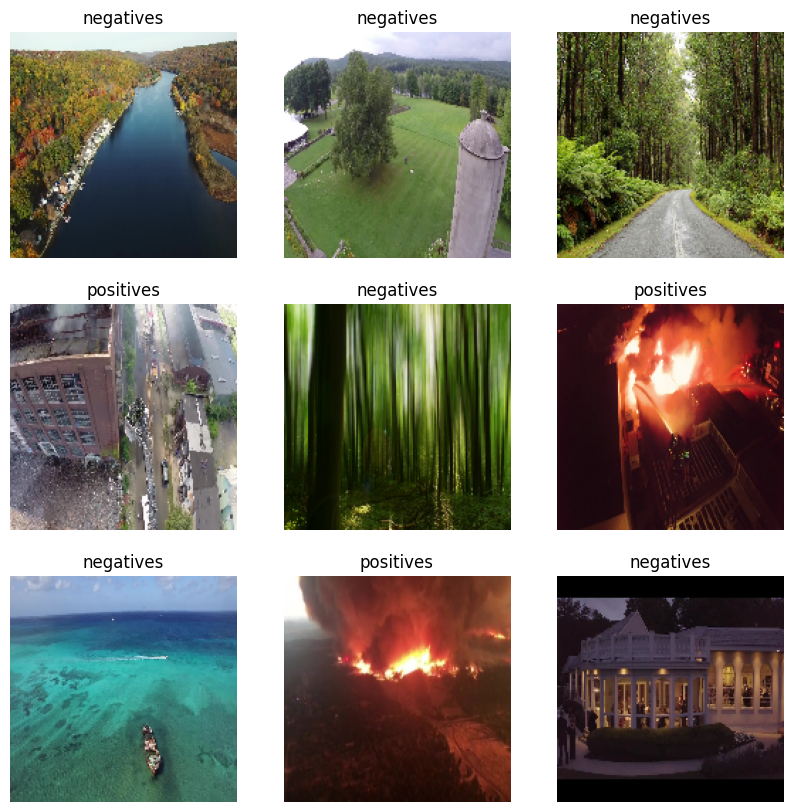

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# some buffering shit?
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# TODO: add more
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

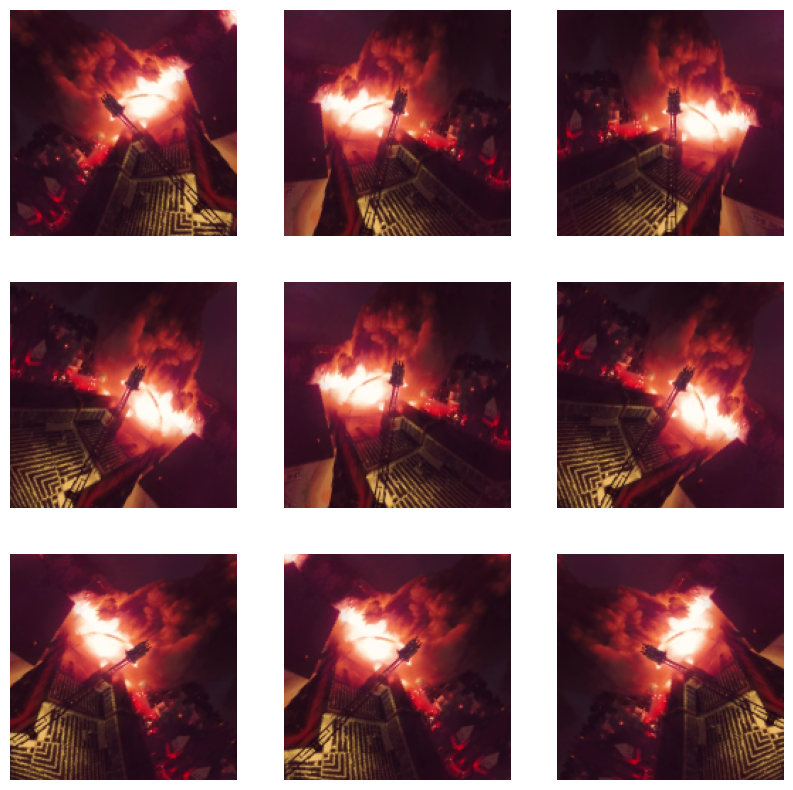

In [ ]:
# augmentation examples
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# guessing this does norm, maybe vectorizes imgs?
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# example batch from train ds
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(512, 5, 5, 1280)


In [ ]:
# freeze img_net backbone
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
# add pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(512, 1280)


In [ ]:
# batch shape
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(512, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [ ]:
# weights and biases
len(model.trainable_variables)

2

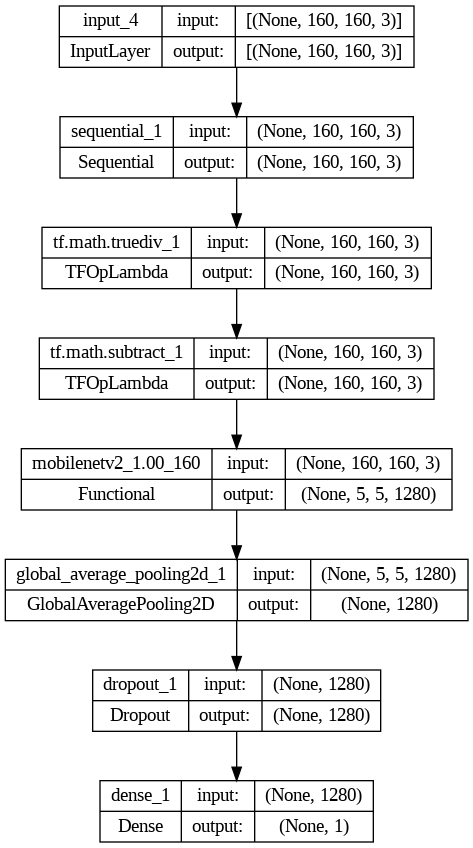

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate = 1e-4 # should be fine for now ig?
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
# sanity check, we are not already fit to our val dataset
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 2s 2s/step - loss: 0.5908 - accuracy: 0.6859
initial loss: 0.59
initial accuracy: 0.69


In [ ]:
num_epochs = 100
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
5/5 [==============================] - 18s 707ms/step - loss: 0.6979 - accuracy: 0.6097 - val_loss: 0.5732 - val_accuracy: 0.7173
Epoch 2/100
5/5 [==============================] - 11s 403ms/step - loss: 0.6732 - accuracy: 0.6317 - val_loss: 0.5566 - val_accuracy: 0.7225
Epoch 3/100
5/5 [==============================] - 11s 405ms/step - loss: 0.6358 - accuracy: 0.6589 - val_loss: 0.5409 - val_accuracy: 0.7592
Epoch 4/100
5/5 [==============================] - 11s 405ms/step - loss: 0.6131 - accuracy: 0.6688 - val_loss: 0.5246 - val_accuracy: 0.7644
Epoch 5/100
5/5 [==============================] - 11s 416ms/step - loss: 0.6033 - accuracy: 0.6839 - val_loss: 0.5094 - val_accuracy: 0.7801
Epoch 6/100
5/5 [==============================] - 11s 415ms/step - loss: 0.5794 - accuracy: 0.7003 - val_loss: 0.4928 - val_accuracy: 0.8063
Epoch 7/100
5/5 [==============================] - 11s 407ms/step - loss: 0.5438 - accuracy: 0.7340 - val_loss: 0.4762 - val_accuracy: 0.8220
Epoch 

In [ ]:
save_path = r"/content/drive/MyDrive/AI Club/jetson-drone-project-main/mobilenet/model.h5"
tf.keras.saving.save_model(
    model,
    save_path
)

<ipython-input-45-85a5f31a2c7a>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.saving.save_model(


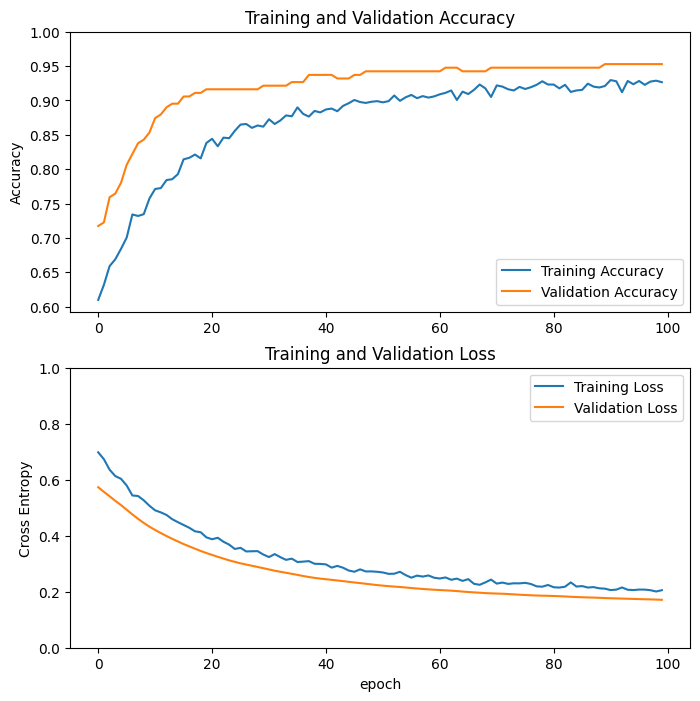

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 510ms/step - loss: 0.1711 - accuracy: 0.9529
Test accuracy : 0.9528796076774597
Predictions:
 [1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1
 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0
 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0
 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1
 1 1 0 1 1 0]
Labels:
 [1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1
 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0
 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0
 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1
 1 1 0 1 1 0]


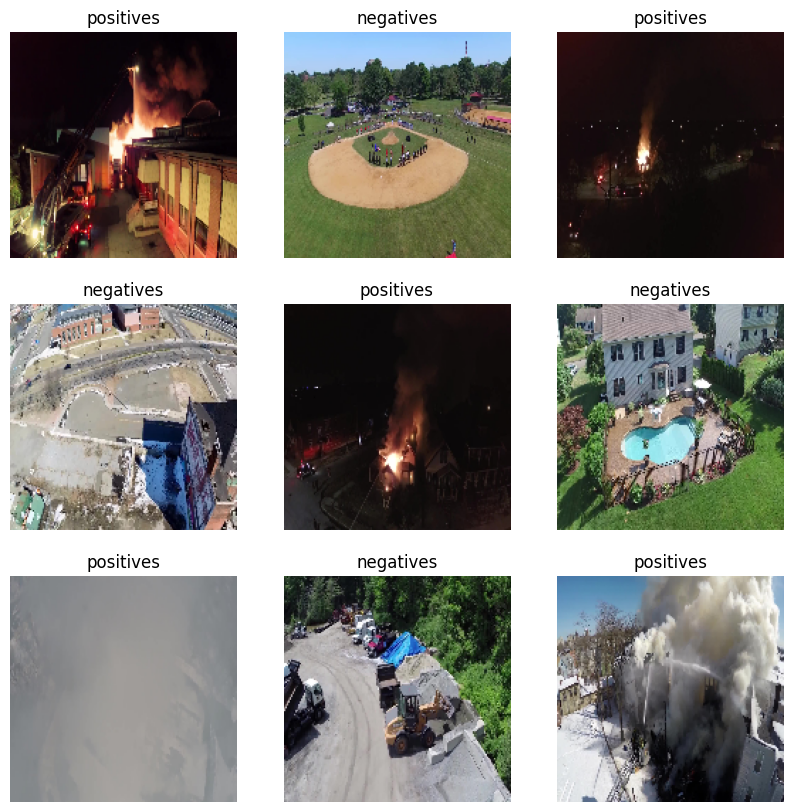

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")